# Run limma differential expression analysis
Compare CTRL and ENDO cells using the genotype as a covariate

In [2]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

### Load raw counts

In [41]:
# anndata_sec <- readRDS('/nfs/team292/lg18/endometriosis/MiloR_objects/cells_mesenchymal_SECRETORY_integrated.rds')
# anndata_prolif <- readRDS('/nfs/team292/lg18/endometriosis/MiloR_objects/cells_mesenchymal_PROLIFERATIVE_integrated.rds')
# anndata <- merge(anndata_sec, y = anndata_prolif)
# anndata

In [42]:
anndata <- readRDS('/nfs/team292/lg18/endometriosis/SeuratR_objects/cells_immune.rds')
anndata

An object of class Seurat 
14635 features across 6085 samples within 1 assay 
Active assay: RNA (14635 features, 0 variable features)

In [43]:
anndata$classification = paste(anndata$celltype, anndata$disease, sep='-') # split celltype by disease status
table(anndata$disease)
anndata


Ctrl Endo 
3098 2987 

An object of class Seurat 
14635 features across 6085 samples within 1 assay 
Active assay: RNA (14635 features, 0 variable features)

In [44]:
# estimate % cells expressing a gene in each class
plot <- DotPlot(object = anndata, features = rownames(anndata), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [45]:
anndata_sce <- as.SingleCellExperiment(anndata)

### Prepare the pseudobulk count matrix:

In [46]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste(colData(anndata_sce)$dataset, 
                                colData(anndata_sce)$disease, 
                                colData(anndata_sce)$celltype, 
                                colData(anndata_sce)$genotype, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$Group)

,GarciaAlonso-Ctrl-eM1-A13-1,GarciaAlonso-Ctrl-eM1-A13-10,GarciaAlonso-Ctrl-eM1-A13-2,GarciaAlonso-Ctrl-eM1-A13-3,GarciaAlonso-Ctrl-eM1-A13-4,GarciaAlonso-Ctrl-eM1-A13-5,GarciaAlonso-Ctrl-eM1-A13-6,GarciaAlonso-Ctrl-eM1-A13-7,GarciaAlonso-Ctrl-eM1-A13-8,GarciaAlonso-Ctrl-eM1-A13-9,⋯,Wang-Ctrl-uNK3-SAMN15049051-1,Wang-Ctrl-uNK3-SAMN15049051-10,Wang-Ctrl-uNK3-SAMN15049051-2,Wang-Ctrl-uNK3-SAMN15049051-3,Wang-Ctrl-uNK3-SAMN15049051-4,Wang-Ctrl-uNK3-SAMN15049051-5,Wang-Ctrl-uNK3-SAMN15049051-6,Wang-Ctrl-uNK3-SAMN15049051-7,Wang-Ctrl-uNK3-SAMN15049051-8,Wang-Ctrl-uNK3-SAMN15049051-9
A1BG,2,5,5,5,5,10,8,7,6,6,⋯,1,0,1,1,1,2,0,0,0,0
A2M,14,9,11,28,14,15,31,25,29,18,⋯,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,1,0,0,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0



 eM1-Ctrl  eM1-Endo  eM2-Ctrl  eM2-Endo uNK1-Ctrl uNK1-Endo uNK3-Ctrl uNK3-Endo 
      150        83       151       106        90        71       236       117 


 Ctrl_Superficial Ctrl_whole_uterus  Endo_Superficial 
              567                60               377 

## Run DEG per celltype

In [47]:
table(summed$celltype)
DEGs_list = list()


 eM1  eM2 uNK1 uNK3 
 233  257  161  353 

### Uncorrected

[1] "eM1"
[1] "eM2"


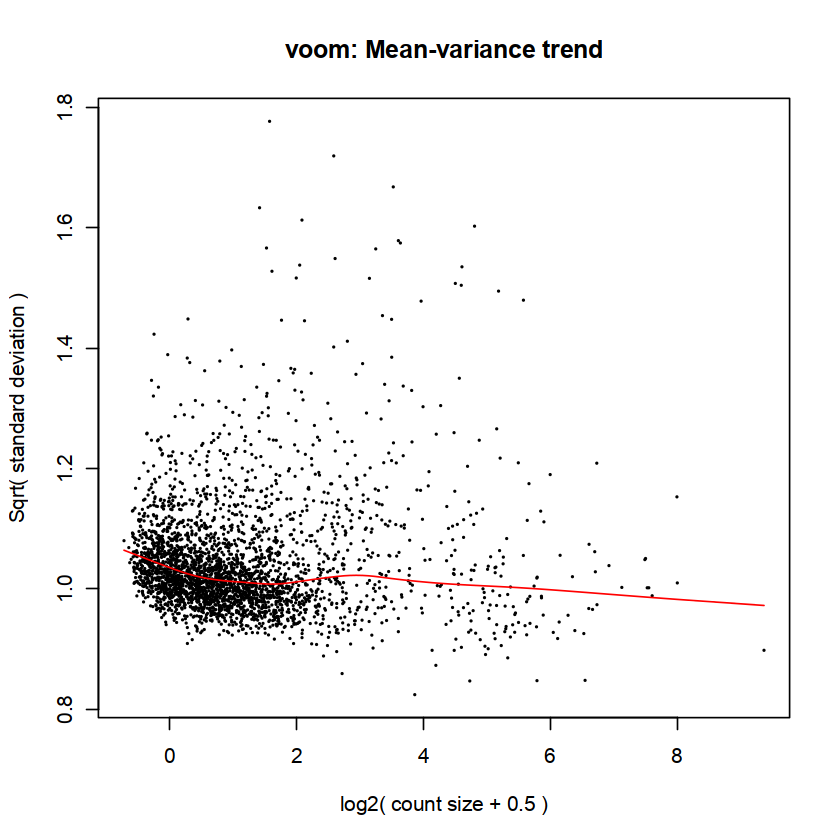

[1] "uNK1"


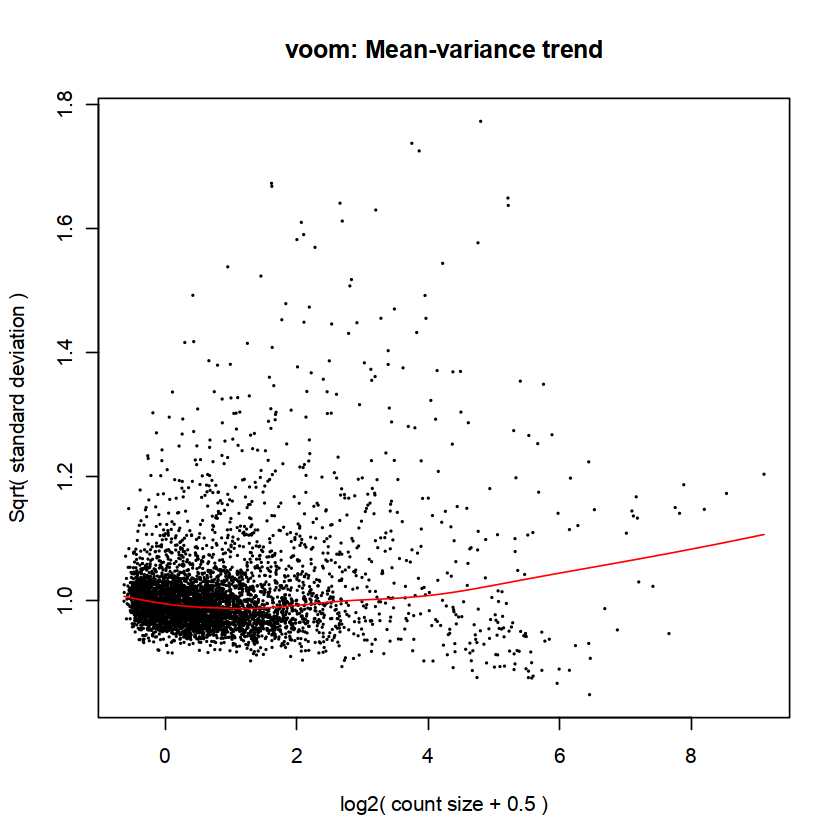

[1] "uNK3"


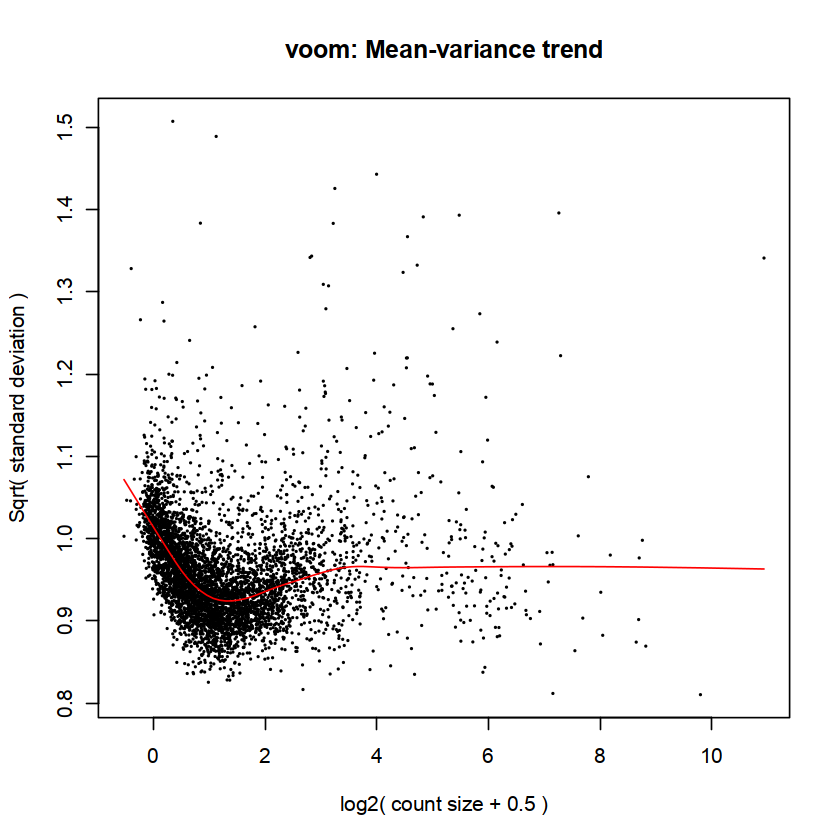

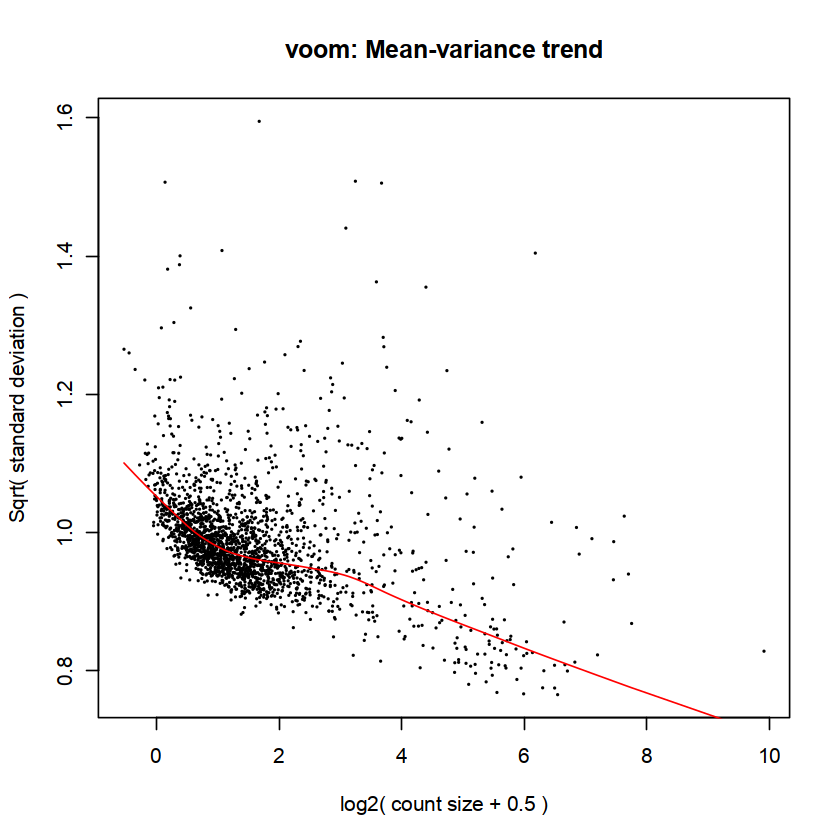

In [48]:
for (celltypeOf_interest in unique(summed$celltype) ){
#     celltypeOf_interest = 'dStromal_mid'
    print(celltypeOf_interest)
    
    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$celltype == celltypeOf_interest)

    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
#     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$genotype)
    genes10percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 10 ] # get genes with > 10% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes10percent
    y <- y[ keep ,]

    ##see how many genes were kept 
    summary(keep)


    # (2) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    # Extract the dataset ID from the meta.data, then create the design matrix
    ## Create the design matrix and include the dataset as a covariate:
#     design <- model.matrix(~ 0 + summed_celltype$Group + summed_celltype$genotype)
    design <- model.matrix(~ 0 + summed_celltype$Group)
    # Have a look
    head(design)

    # change column/rownames names to more simple group names: 
    colnames(design) = gsub('summed_celltype\\$', '', colnames(design))
    colnames(design) = gsub('GroupEndo_Superficial', 'ENDOMETRIOSIS', colnames(design))
    colnames(design) = gsub('GroupCtrl_Superficial', 'CONTROL', colnames(design))
    colnames(design)
    rownames(design) <- colData(summed_celltype)$metacell_id

    # Have a look
    head(design)

    # (3) Specify which contrast to analyse:
    contrast.mat <- limma::makeContrasts(CONTROL-ENDOMETRIOSIS, levels = design) # positive values will mean upregulation in CONTROL

    # (4) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    dge <- edgeR::calcNormFactors(y)  

    # (5) Do limma DEG
    vm <- limma::voom(dge, design = design, plot = TRUE)
    fit <- limma::lmFit(vm, design = design)
    fit.contrasts <- limma::contrasts.fit(fit, contrast.mat)
    fit.contrasts <- limma::eBayes(fit.contrasts)

    # (6) We can use topTable to get the most significantly differentially expressed genes, and save the full DE results to an object. How many genes are significant? Are you suprised by this number?
    # Show the top differentially expressed genes:
    limma::topTable(fit.contrasts, sort.by = "P")
    limma_de <- limma::topTable(fit.contrasts, number = Inf, sort.by = "P")
    limma_de$Gene = rownames(limma_de)
    DEGs_list[[celltypeOf_interest]] = limma_de
    
}

# Save DEGs
limma_de = melt(DEGs_list, id.vars = names(DEGs_list[[1]]))
limma_de$meaning = ifelse(limma_de$logFC > 0, 'up_CONTROL', 'up_ENDOMETRIOSIS')
limma_de$meaning[ limma_de$adj.P.Val > 0.05 ] = 'not significant'
limma_de = limma_de[ order(limma_de$logFC, decreasing = T), ]
colnames(limma_de)[8] = 'celltype'
limma_de = limma_de[, c('celltype', 'Gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B', 'meaning') ]
write.table(limma_de, 
            file='/nfs/team292/lg18/endometriosis/DEGs_endometriosis/cells_immune_uncorrected.tsv', sep='\t', quote=F, row.names=F)

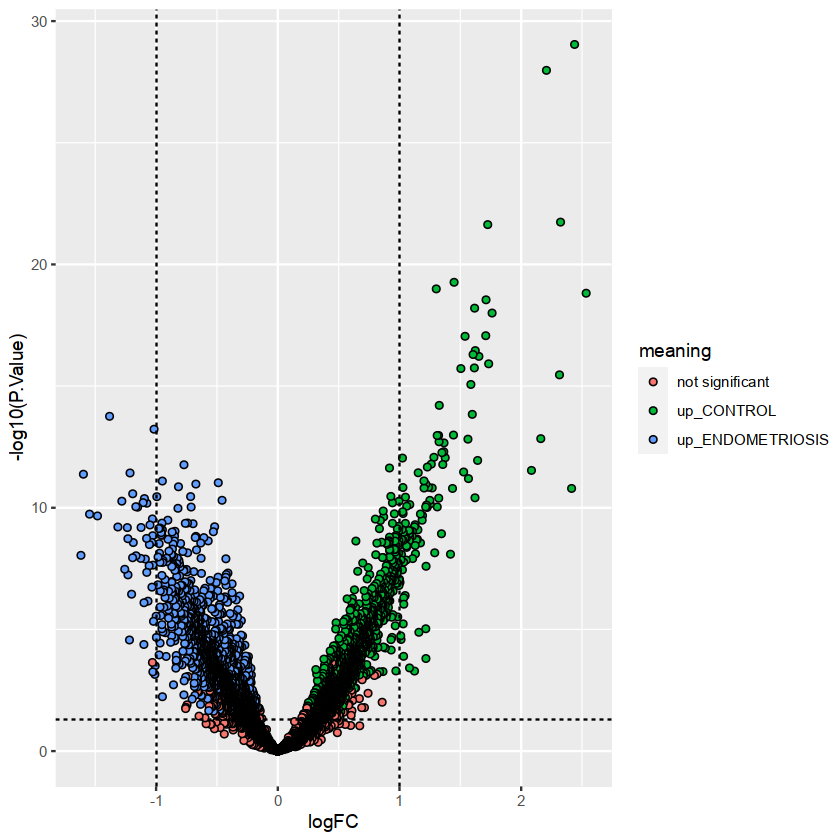

In [49]:
limma_de %>%
  ggplot(aes(x = logFC,
             y = -log10(P.Value),
             fill = meaning)) + 
  geom_point(shape = 21, colour = "black") +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed") + 
  geom_vline(xintercept = c(log2(0.5), log2(2)),
             linetype = "dashed")

### Corrected by genotype

[1] "eM1"
Coefficients not estimable: genotypeGSM6605436 genotypeSAMN15049050 genotypeSE06 


Warning message:
“Partial NA coefficients for 3044 probe(s)”


Coefficients not estimable: genotypeGSM6605436 genotypeSAMN15049050 genotypeSE06 


Warning message:
“Partial NA coefficients for 3044 probe(s)”


[1] "eM2"
Coefficients not estimable: genotypeA70 genotypeGSM6605436 genotypeSAMN15049046 genotypeSAMN15049050 genotypeSAMN15049051 genotypeSE03 genotypeSE06 


Warning message:
“Partial NA coefficients for 4907 probe(s)”


Coefficients not estimable: genotypeA70 genotypeGSM6605436 genotypeSAMN15049046 genotypeSAMN15049050 genotypeSAMN15049051 genotypeSE03 genotypeSE06 


Warning message:
“Partial NA coefficients for 4907 probe(s)”


[1] "uNK1"
Coefficients not estimable: genotypeA30 genotypeA70 genotypeES345 genotypeFX1119 genotypeFX1176 genotypeFX1259 genotypeFX1285 genotypeFX1289 genotypeGSM6605436 genotypeSAMN15049042 genotypeSAMN15049046 genotypeSAMN15049048 genotypeSAMN15049049 genotypeSAMN15049050 genotypeSAMN15049051 genotypeSE02 genotypeSE03 genotypeSE06 


Warning message:
“Partial NA coefficients for 4970 probe(s)”


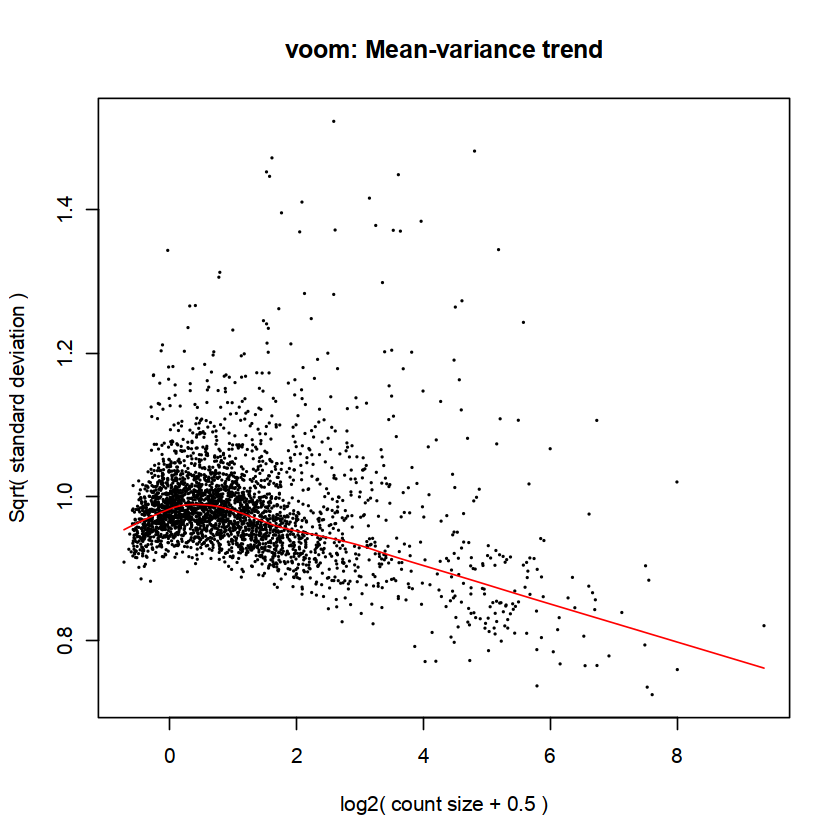

Coefficients not estimable: genotypeA30 genotypeA70 genotypeES345 genotypeFX1119 genotypeFX1176 genotypeFX1259 genotypeFX1285 genotypeFX1289 genotypeGSM6605436 genotypeSAMN15049042 genotypeSAMN15049046 genotypeSAMN15049048 genotypeSAMN15049049 genotypeSAMN15049050 genotypeSAMN15049051 genotypeSE02 genotypeSE03 genotypeSE06 


Warning message:
“Partial NA coefficients for 4970 probe(s)”


[1] "uNK3"
Coefficients not estimable: genotypeGSM6605436 genotypeSE06 


Warning message:
“Partial NA coefficients for 2079 probe(s)”


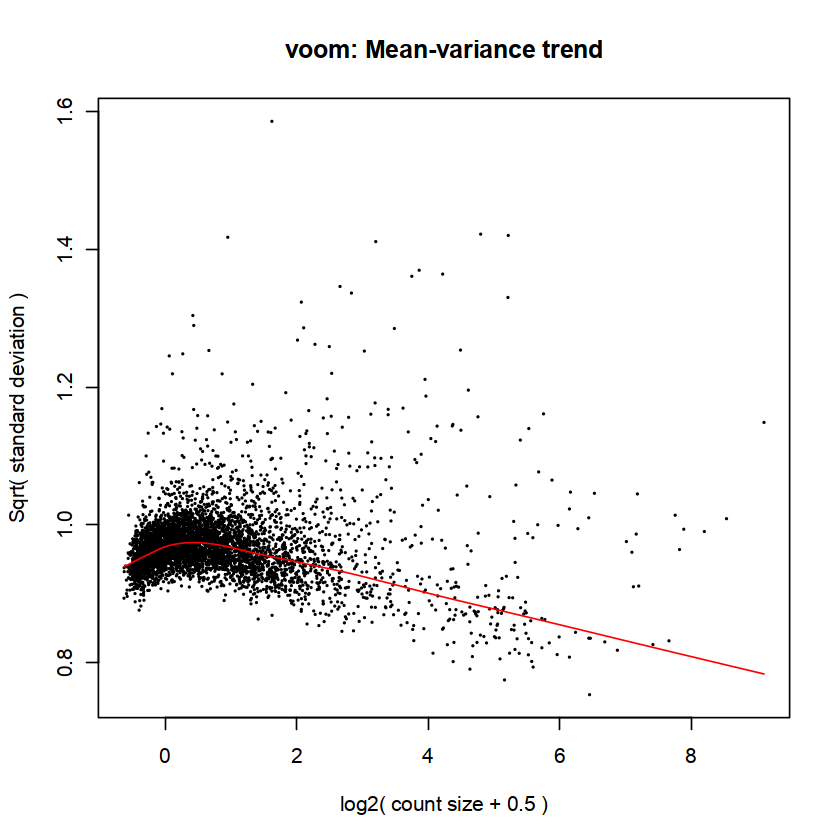

Coefficients not estimable: genotypeGSM6605436 genotypeSE06 


Warning message:
“Partial NA coefficients for 2079 probe(s)”


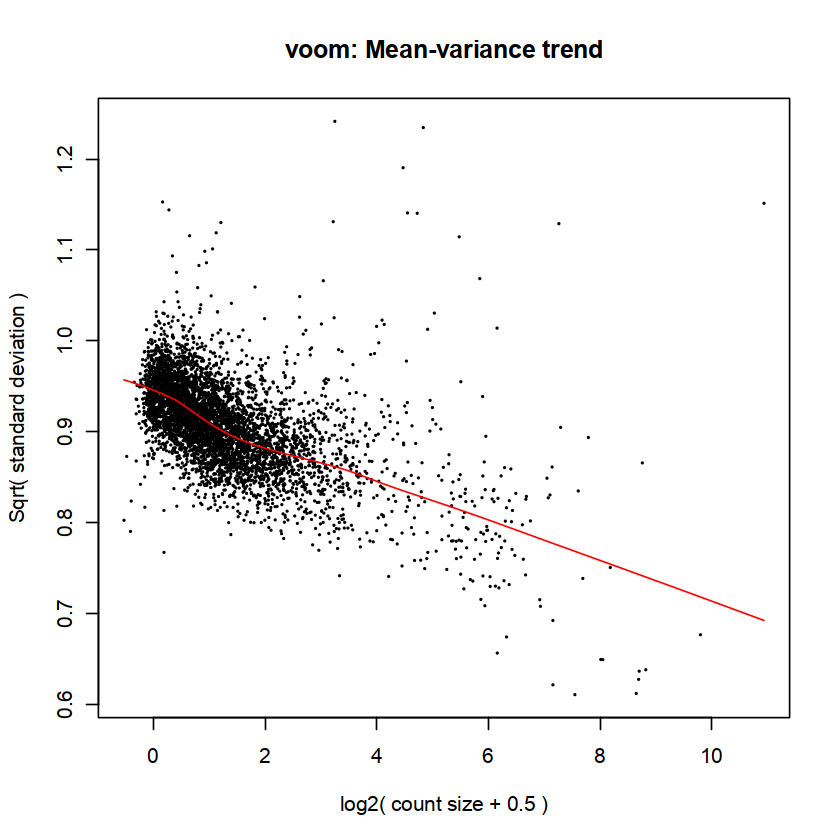

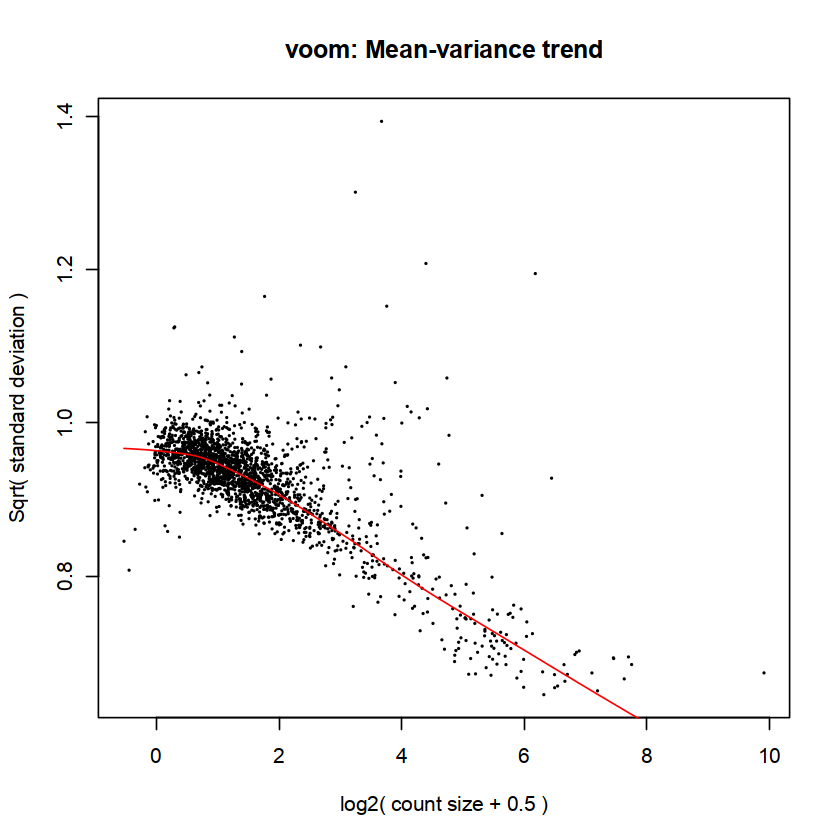

In [50]:
for (celltypeOf_interest in unique(summed$celltype) ){
#     celltypeOf_interest = 'dStromal_mid'
    print(celltypeOf_interest)
    
    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$celltype == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
#     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$genotype)
    genes10percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 10 ] # get genes with > 10% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes10percent
    y <- y[ keep ,]

    ##see how many genes were kept 
    summary(keep)


    # (2) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    # Extract the dataset ID from the meta.data, then create the design matrix
    ## Create the design matrix and include the dataset as a covariate:
    design <- model.matrix(~ 0 + summed_celltype$Group + summed_celltype$genotype)
#     design <- model.matrix(~ 0 + summed_celltype$Group)
    # Have a look
    head(design)

    # change column/rownames names to more simple group names: 
    colnames(design) = gsub('summed_celltype\\$', '', colnames(design))
    colnames(design) = gsub('GroupEndo_Superficial', 'ENDOMETRIOSIS', colnames(design))
    colnames(design) = gsub('GroupCtrl_Superficial', 'CONTROL', colnames(design))
    colnames(design)
    rownames(design) <- colData(summed_celltype)$metacell_id

    # Have a look
    head(design)

    # (3) Specify which contrast to analyse:
    contrast.mat <- limma::makeContrasts(CONTROL-ENDOMETRIOSIS, levels = design) # positive values will mean upregulation in CONTROL

    # (4) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    dge <- edgeR::calcNormFactors(y)  

    # (5) Do limma DEG
    vm <- limma::voom(dge, design = design, plot = TRUE)
    fit <- limma::lmFit(vm, design = design)
    fit.contrasts <- limma::contrasts.fit(fit, contrast.mat)
    fit.contrasts <- limma::eBayes(fit.contrasts)

    # (6) We can use topTable to get the most significantly differentially expressed genes, and save the full DE results to an object. How many genes are significant? Are you suprised by this number?
    # Show the top differentially expressed genes:
    limma::topTable(fit.contrasts, sort.by = "P")
    limma_de <- limma::topTable(fit.contrasts, number = Inf, sort.by = "P")
    limma_de$Gene = rownames(limma_de)
    DEGs_list[[celltypeOf_interest]] = limma_de
    
}

# Save DEGs
limma_de = melt(DEGs_list, id.vars = names(DEGs_list[[1]]))
limma_de$meaning = ifelse(limma_de$logFC > 0, 'up_CONTROL', 'up_ENDOMETRIOSIS')
limma_de = limma_de[ order(limma_de$logFC, decreasing = T), ]
limma_de$meaning[ limma_de$adj.P.Val > 0.05 ] = 'not significant'
colnames(limma_de)[8] = 'celltype'
limma_de = limma_de[, c('celltype', 'Gene', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B', 'meaning') ]
write.table(limma_de, 
            file='/nfs/team292/lg18/endometriosis/DEGs_endometriosis/cells_immune_corrected.tsv', sep='\t', quote=F, row.names=F)


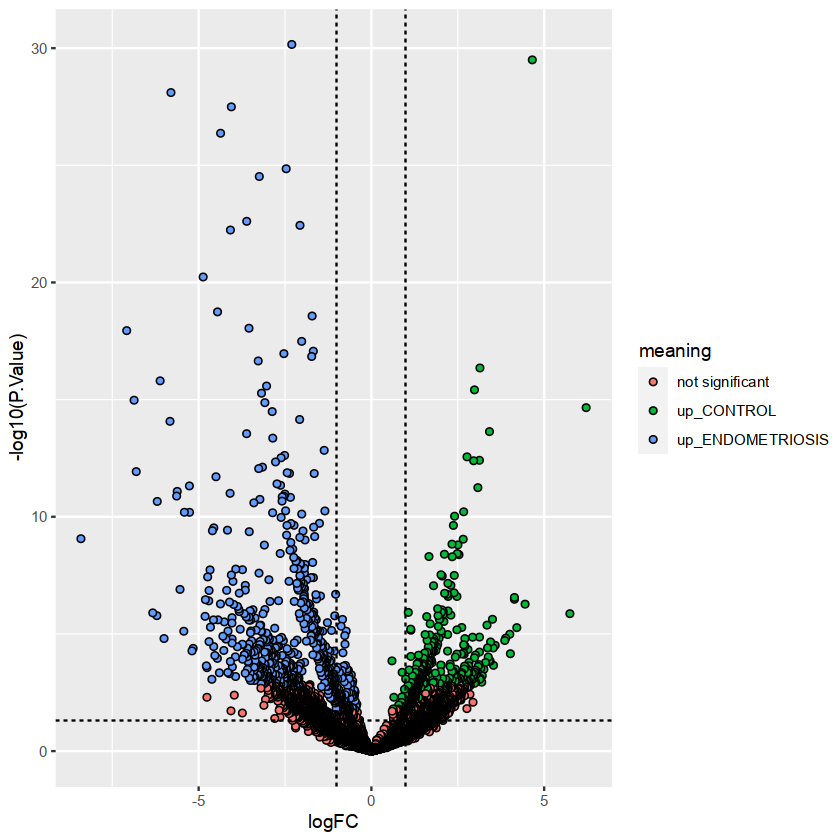

In [51]:
limma_de %>%
  ggplot(aes(x = logFC,
             y = -log10(P.Value),
             fill = meaning)) + 
  geom_point(shape = 21, colour = "black") +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed") + 
  geom_vline(xintercept = c(log2(0.5), log2(2)),
             linetype = "dashed")

## Explore results

In [52]:
head(subset(limma_de, adj.P.Val < 0.05), n = 20)
tail(subset(limma_de, adj.P.Val < 0.05), n = 20)

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7952,uNK1,MTRNR2L12,6.215502,5.329830,8.566882,2.204690e-15,1.095731e-11,23.7748327,up_CONTROL
3075,eM2,LYZ,5.745330,10.067144,4.936525,1.365970e-06,2.063473e-04,5.0299918,up_CONTROL
12923,uNK3,MTRNR2L12,4.656663,7.496934,12.538024,3.169653e-30,3.294854e-27,57.5028785,up_CONTROL
7966,uNK1,S100A13,4.447842,5.402642,5.171880,5.356226e-07,1.774696e-04,5.8926107,up_CONTROL
7971,uNK1,DRAXIN,4.208729,5.515659,4.668285,5.385528e-06,1.338304e-03,3.7764343,up_CONTROL
7962,uNK1,AL627171.2,4.140713,5.382885,5.271930,3.318790e-07,1.499490e-04,6.3458340,up_CONTROL
7961,uNK1,MTRNR2L8,4.139167,4.584685,5.308695,2.778963e-07,1.381145e-04,6.4228144,up_CONTROL
33,eM1,LYZ,4.022982,11.213696,4.052458,6.988307e-05,6.303490e-03,1.4048408,up_CONTROL
7974,uNK1,GEMIN7,4.005982,4.862137,4.519777,1.028872e-05,2.223259e-03,3.1867003,up_CONTROL


,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3122,eM2,CCL3,-5.158954,10.788817,-4.165980,4.130713e-05,2.598642e-03,1.863450,up_ENDOMETRIOSIS
3129,eM2,SELENOP,-5.191584,9.795776,-4.105337,5.297968e-05,3.058486e-03,1.633977,up_ENDOMETRIOSIS
3056,eM2,NR4A1,-5.263400,7.685688,-6.795429,6.457931e-11,2.640756e-08,14.378140,up_ENDOMETRIOSIS
3051,eM2,ABL2,-5.267092,6.854438,-7.221982,4.826586e-12,3.383437e-09,16.829690,up_ENDOMETRIOSIS
3055,eM2,IL1RN,-5.412441,6.371241,-6.795828,6.442612e-11,2.640756e-08,14.382520,up_ENDOMETRIOSIS
7973,uNK1,CRTAM,-5.429424,6.802973,-4.587512,7.673115e-06,1.733426e-03,3.425668,up_ENDOMETRIOSIS
7959,uNK1,IGFBP2,-5.539312,8.120107,-5.470296,1.260544e-07,7.466648e-05,7.109550,up_ENDOMETRIOSIS
3052,eM2,DNAJB1,-5.619181,8.491545,-7.135004,8.260678e-12,5.066893e-09,16.341374,up_ENDOMETRIOSIS
3053,eM2,CD83,-5.636237,8.383992,-7.060328,1.305861e-11,7.119844e-09,15.902824,up_ENDOMETRIOSIS


### Plot genes of interest

In [53]:
genes = c('DKK1', 
          'IGF1', 'IGF2',  'IGFBP1', 'IGFBP3', 'IGF1R', 'INSR',  'IRS2', 'TMEM219',
          'GDF7',  'LEFTY2', 'LEFTY1', 'BMP2',
          'CALB2', 'GREB1'
         )
significant_limma_de = subset(limma_de, Gene %in% genes & abs(logFC) > 0.5)
significant_limma_de
significant_genes = limma_de$Gene

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
397,eM1,TMEM219,1.1646371,7.092999,2.1489635,0.03270815,0.25021326,-3.934104,not significant
4019,eM2,TMEM219,1.0819895,7.200251,1.7384608,0.08322576,0.41886032,-4.730491,not significant
13587,uNK3,IGF1,1.0437947,6.377123,2.4557909,0.01452383,0.04533789,-3.641998,up_CONTROL
10761,uNK1,TMEM219,-0.6536144,6.698091,-0.8085329,0.41969072,0.74229996,-5.683439,not significant
3938,eM2,IGF1,-1.3644867,7.548649,-1.8180310,0.07012486,0.38490233,-4.615478,not significant
304,eM1,IGF1,-1.6342513,6.009102,-2.3209100,0.02118952,0.21054954,-3.573416,not significant


In [54]:
gwas_genes1 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/loci_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]
gwas_genes2 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/credible_sets_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]
gwas_genes3 = read.csv('/nfs/team292/lg18/endometriosis/fGWAs/Rahmioglu2023_endometriosis/metaregression_genes.tsv', stringsAsFactors = F, sep ='\t')[,1]

endo_genes = c(gwas_genes1, gwas_genes2, gwas_genes3)
subset(limma_de, Gene %in% endo_genes & adj.P.Val < 0.05)
significant_genes = subset(limma_de, Gene %in% endo_genes & adj.P.Val < 0.05)$Gene
significant_genes

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
13085,uNK3,ID4,1.936106,5.699585,4.643942,4.780525e-06,0.0000606019,3.730280,up_CONTROL
13587,uNK3,IGF1,1.043795,6.377123,2.455791,1.452383e-02,0.0453378863,-3.641998,up_CONTROL


[1] "ID4"  "IGF1"

In [55]:
genes = c('TYRO3', 'IGF2', 'HES1')
subset(limma_de, Gene %in% genes)

,celltype,Gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,meaning
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5368,eM2,HES1,-0.8972505,6.301885,-0.9886261,0.32369723,0.6834692,-5.718649,not significant
584,eM1,HES1,-1.7489692,6.631810,-1.8304693,0.06850661,0.3564738,-4.517267,not significant


## Visualise data as dotplot in summed dataset

In [56]:
summed_celltype <- logNormCounts(summed_celltype)

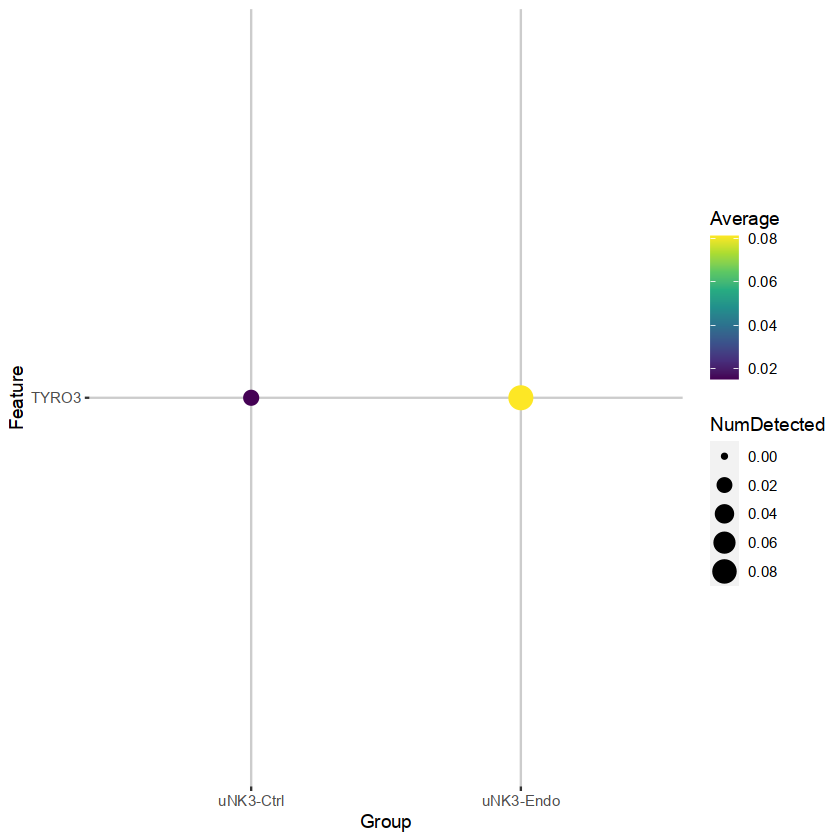

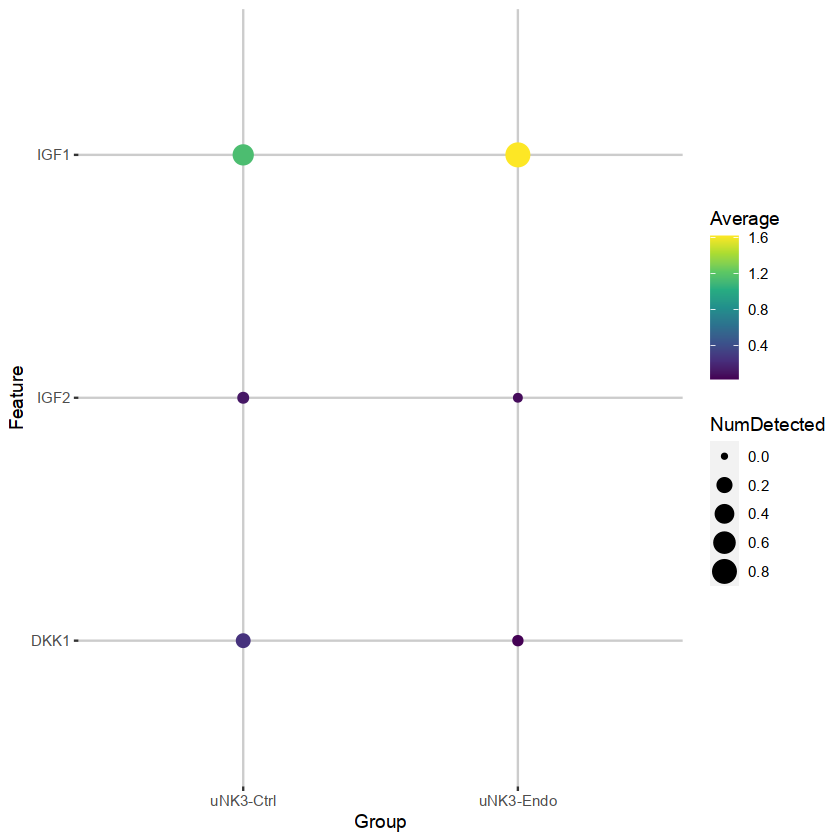

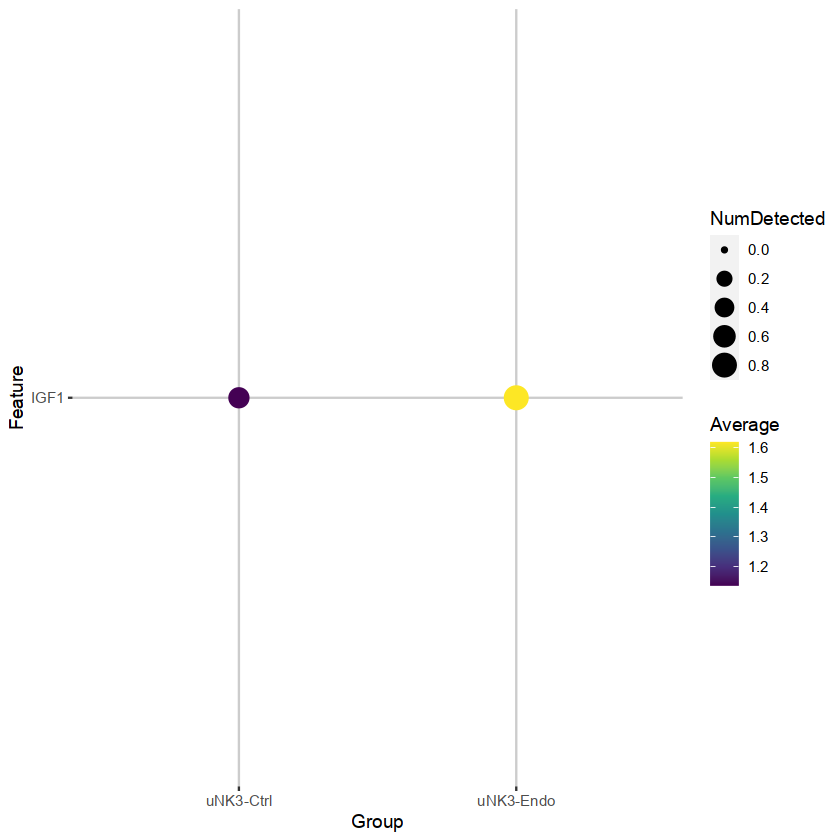

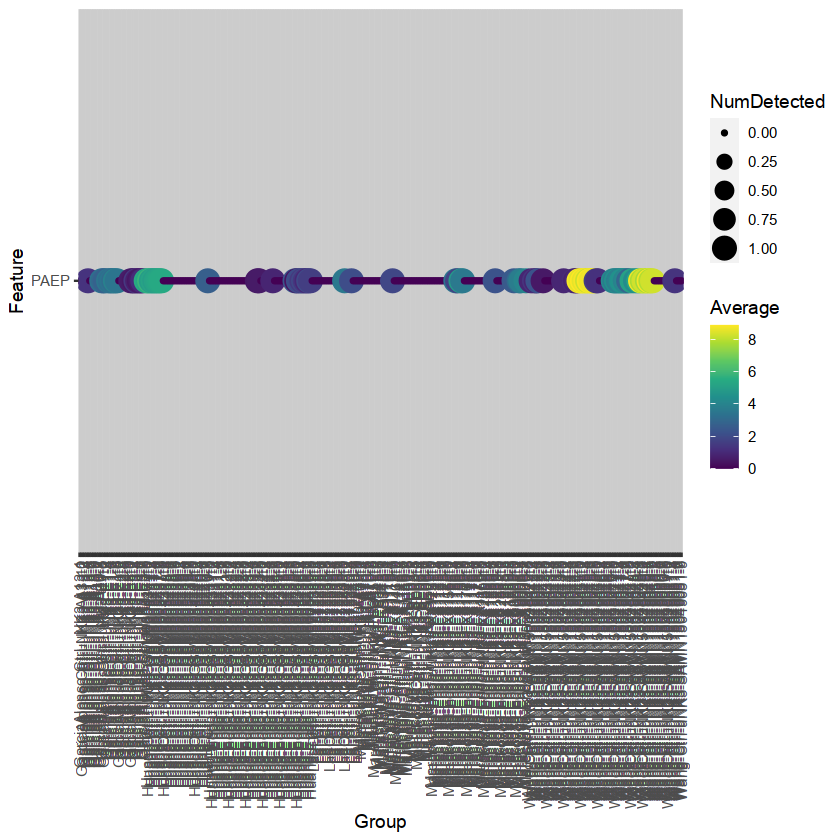

In [57]:
plotDots(summed_celltype, features=c('TYRO3'), group="classification")
plotDots(summed_celltype, features=c('DKK1', 'IGF2', 'IGF1'), group="classification")
plotDots(summed_celltype, features=c('IGF1'), group="classification")
plotDots(summed_celltype, features=c('PAEP'), group="metacell_id") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


## Visualise data as dotplot in original sc dataset

In [58]:
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Centering and scaling data matrix



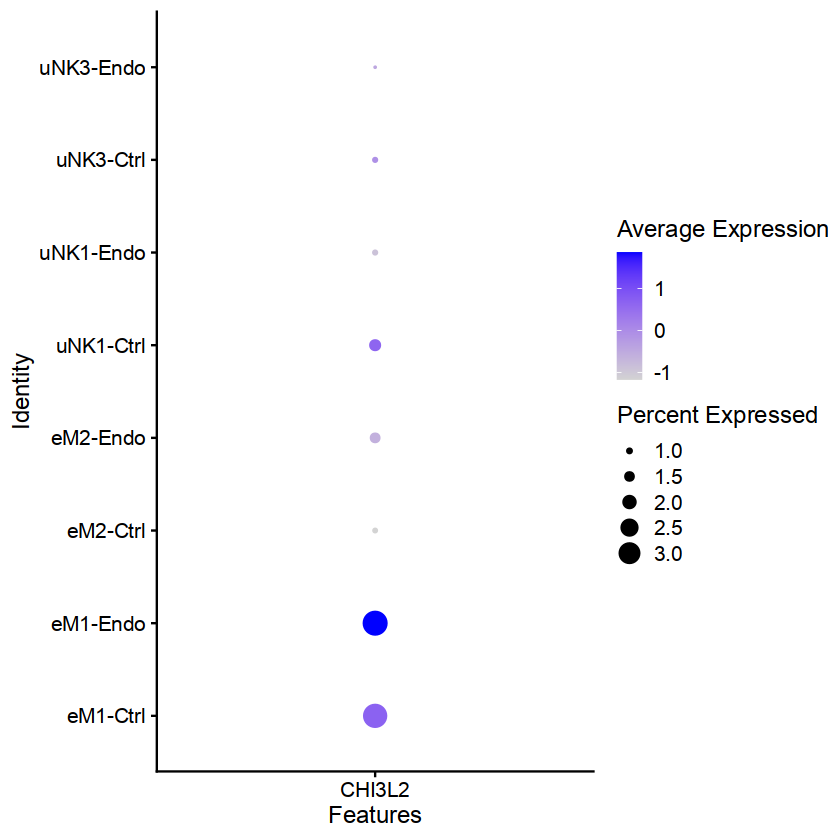

In [59]:
Seurat::DotPlot(anndata, features = c('CHI3L2'), group.by = 'classification')

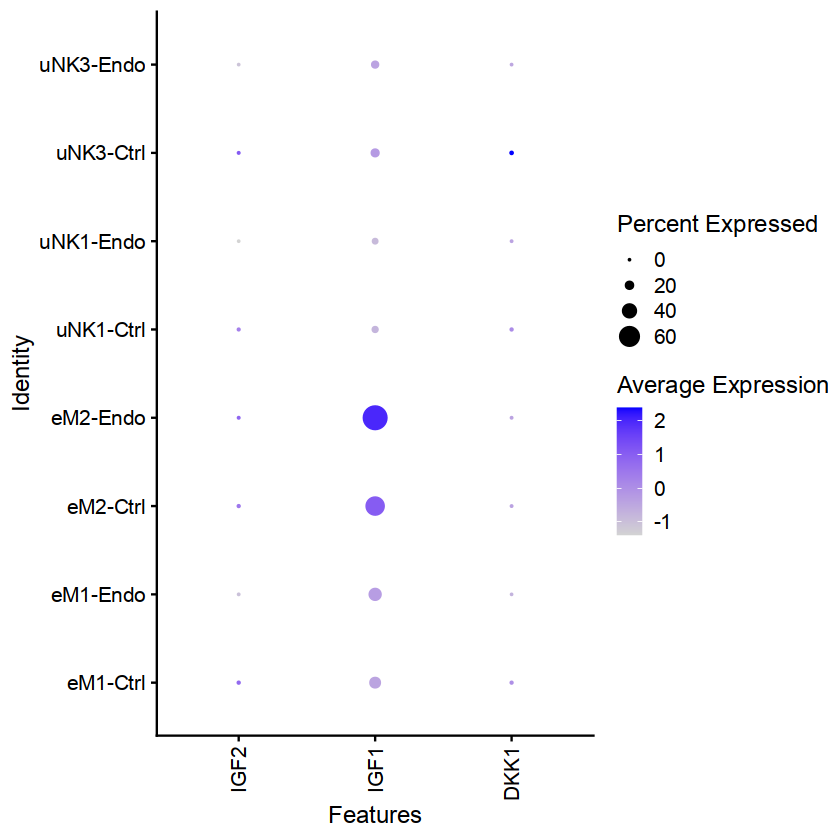

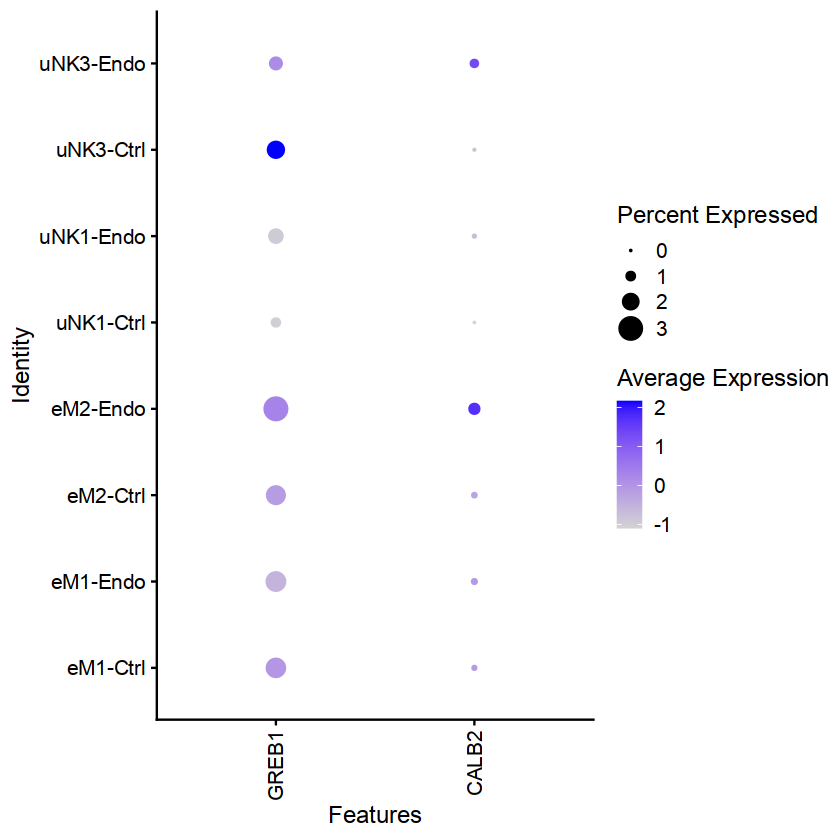

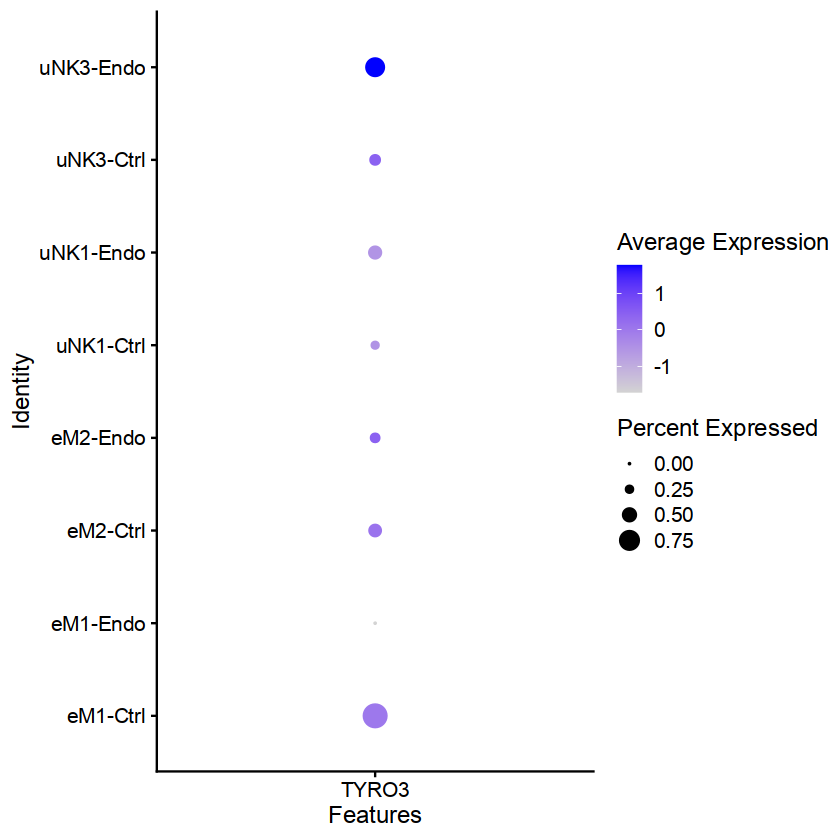

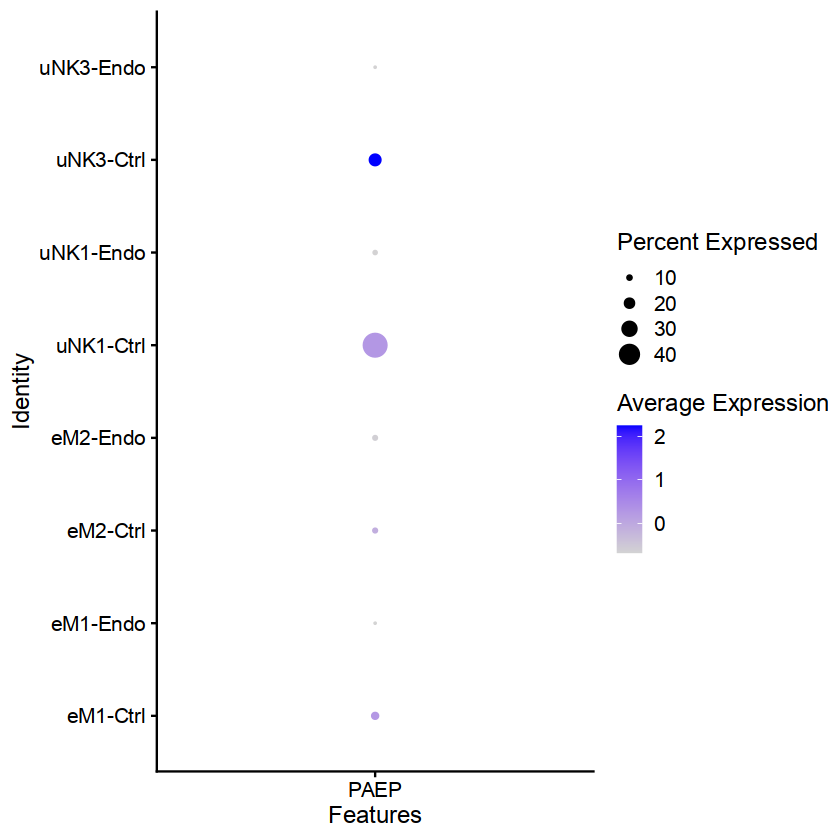

In [60]:
Seurat::DotPlot(anndata, features = c('IGF2', 'IGF1', 'DKK1'), group.by = 'classification')  + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
Seurat::DotPlot(anndata, features = c('GREB1', 'CALB2'), group.by = 'classification')  + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
Seurat::DotPlot(anndata, features = c('TYRO3'), group.by = 'classification')
Seurat::DotPlot(anndata, features = c('PAEP'), group.by = 'classification')

In [61]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/miloR-env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.40.2                SeuratObject_4.1.3         
 [5] Seurat_4.3.0                patchwork_1.1.2            
 [7] dplyr_1.1.2                 scran_1.26.2               
 [9] scater_1.26.1               ggplot2_3.4.2          